In [1]:
from typing import Tuple, List
from itertools import combinations, permutations
from math import factorial

from skimage import measure
from skimage import filters
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation
from skimage.feature import corner_harris, corner_peaks, corner_subpix
from skimage.morphology import convex_hull_image
from PIL import Image
from scipy import ndimage
from tqdm import tqdm

from src.utils import *
from src.heap import Heap
from src.segmentation import felzenszwalb
from src.form_detection import find_rectangle_candidates, find_best_rectangle, classify_points, get_object_description, get_boundaries_and_corners, get_object_description

In [ ]:
image = load_image("images/monochrome.jpg")
segmented = felzenszwalb(image)

In [ ]:
cutout = get_cutout(segmented == 12)
plt.matshow(cutout)
plt.savefig("cutout.png")

In [15]:
boundaries, corners = get_boundaries_and_corners(cutout, 500)

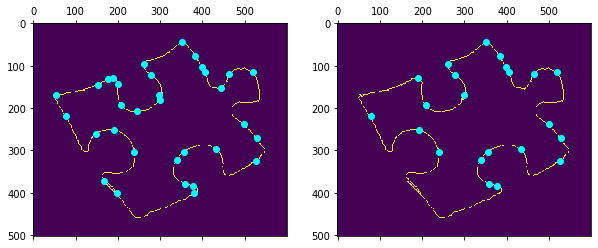

In [21]:
crn = corners[:22]
fig, ax = plt.subplots(ncols=2, figsize=(10, 10))
ax[0].plot(corners[:, 1], corners[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
ax[0].matshow(boundaries)

ax[1].plot(crn[:, 1], crn[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
ax[1].matshow(boundaries)

plt.savefig("boundaries.png")

In [22]:
rectangles = find_rectangle_candidates(cutout, corners[:22], candidate_limit=10)

100%|██████████| 7315/7315 [00:57<00:00, 126.91it/s]


In [23]:
best_rectangle = find_best_rectangle(rectangles)

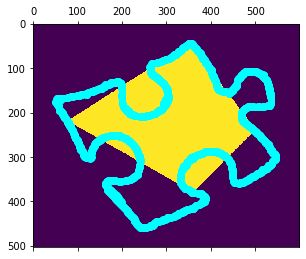

In [24]:
zeros = np.zeros_like(cutout)
for p in best_rectangle:
    zeros[p[0], p[1]] = 1
plt.matshow(convex_hull_image(zeros))
bnd2 = np.argwhere(boundaries == 1)
plt.plot(bnd2[:, 1], bnd2[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
plt.savefig("best_rectangle.png")

In [25]:
np.sum(convex_hull_image(zeros) * cutout) / np.sum(cutout)

0.5965909710930936

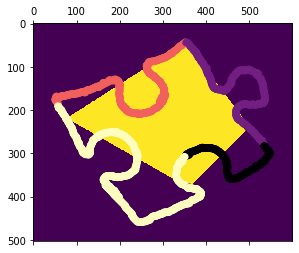

In [26]:
boundary_points = np.argwhere(boundaries == 1)

new_boundary_points, classes = classify_points(best_rectangle, boundary_points, thr=0.75)

fig, ax = plt.subplots()
ax.scatter(new_boundary_points[:, 1], new_boundary_points[:, 0], c=classes, cmap="magma")
ax.matshow(convex_hull_image(zeros))
plt.savefig("classified_borders.png")

In [27]:
from src.utils import center_of_mass
get_object_description(best_rectangle, new_boundary_points, classes, center_of_mass(cutout), cutout.shape, 
                      center_thr=10, max_thr=75)

78.48885271170677 25.345540109230164
82.84987277391431 27.033069227710477
84.38810725256452 17.20030998065118
104.37008687037597 36.16740255312982


'P3B1'

In [28]:
sides = get_sides_from_rectangle(best_rectangle)

82.02438661763951 78.48885271170677
91.6090600941695 82.84987277391431
92.03766341006299 84.38810725256452
127.90739852910458 104.37008687037597


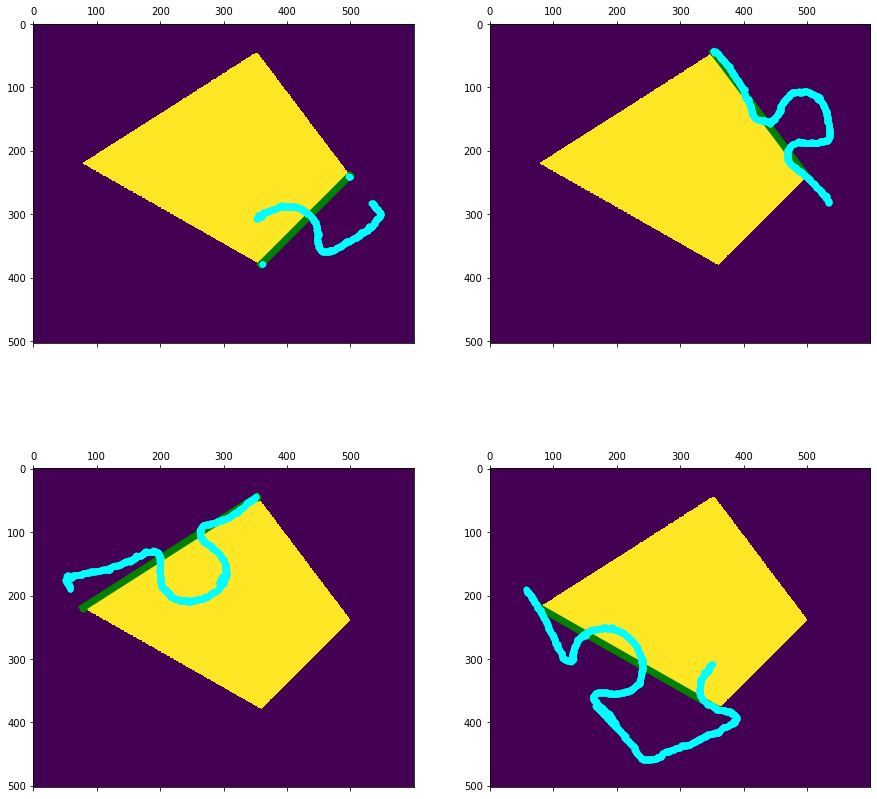

In [29]:
idx = 0
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
for idx in range(4):
    ax = axs[idx // 2][idx % 2]
    bnd = new_boundary_points[classes == idx]
    c = np.mean(bnd, axis=0)
    side = np.array(sides[idx])
    bnd_distances = [point_to_segment_distance(side[0], side[1], bp) for bp in bnd]
    bnd_distances.sort()
    print(bnd_distances[-1], bnd_distances[-int(len(bnd_distances) * 0.1)])
    ax.plot(side[:, 1], side[:, 0], color="green", marker="o", markersize=7, linewidth=7)
    ax.plot(bnd[:, 1], bnd[:, 0], color='cyan', marker='o', linestyle='None', markersize=5)
    ax.matshow(convex_hull_image(zeros))
plt.savefig("4sides.png")